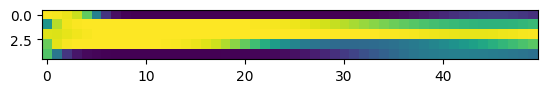

In [34]:
import numpy as np
from scipy.special import expit, logit

class TensorModelWithGenetics:
    def __init__(self, N, P, D, K, R1, R2, T):
        self.N = N  # Number of individuals
        self.P = P  # Number of genetic variants
        self.D = D  # Number of diseases
        self.K = K  # Number of signatures
        self.R1 = R1  # Rank for individual patterns
        self.R2 = R2  # Rank for disease patterns
        self.T = T  # Number of time points
        self.initialized = False
        self.initialize_parameters()

        
    def initialize_parameters(self):
        self.U1 = np.random.randn(self.N, self.K, self.R1) * 0.5  # Increased from 0.01
        self.U2 = create_smooth_basis(self.T, self.R1)
        self.W = np.random.randn(self.D, self.K, self.R2) * 0.5  # Increased from 0.01
        self.U3 = create_smooth_basis(self.T, self.R2)
        self.G = np.random.binomial(2, 0.3, size=(self.N, self.P))
        self.B = np.random.randn(self.P, self.K, self.R1) * 0.05  # Increased from 0.001
        self.C = np.random.randn(self.N, self.K, self.R1) * 0.05  # Increased from 0.001
        self.initialized = True
 
    def get_dimensions(self):
        return {
            'N': self.N,
            'P': self.P,
            'D': self.D,
            'K': self.K,
            'R1': self.R1,
            'R2': self.R2,
            'T': self.T
        }
    def get_parameters(self):
        if not self.initialized:
            raise ValueError("Parameters have not been initialized yet.")
        return {
        'U1': self.U1,
        'U2': self.U2,
        'W': self.W,
        'U3': self.U3,
        'G': self.G,
        'B': self.B,
        'C': self.C
    }
    

    def compute_U1G(self):
        U1G = self.U1.copy()
        genetic_effect = np.einsum('np,pkr->nkr', self.G, self.B)
        U1G += genetic_effect + self.C
        return U1G

    def compute_theta(self):
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.U3)
        theta = np.einsum('nkt,dkt->ndt', lambda_k, phi)
        return theta

    def survival_likelihood(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        log_likelihood = 0
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
                if Y[n, d, t] == 1:
                    log_likelihood += np.log(pi[n, d, t] + 1e-10)
                    pi[n, d, t+1:] = 0
        return log_likelihood

    def compute_gradients(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.U3)
        
        d_theta = np.zeros_like(theta)
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                d_theta[n, d, :t] = -pi[n, d, :t]
                if Y[n, d, t] == 1:
                    d_theta[n, d, t] += 1
        
        d_lambda = np.einsum('ndt,dkt->nkt', d_theta, phi)
        d_phi = np.einsum('ndt,nkt->dkt', d_theta, lambda_k)
        
        d_U1G = np.einsum('nkt,tr->nkr', d_lambda, self.U2)
        d_W = np.einsum('dkt,tr->dkr', d_phi, self.U3)
        
        d_U1 = d_U1G
        d_B = np.einsum('nkr,np->pkr', d_U1G, self.G)
        d_C = d_U1G
        
        return d_U1, d_W, d_B, d_C

    def fit(self, Y, S, num_iterations=1000, learning_rate=1e-4, l2_reg=1e-5, clip_value=1.0, patience=50):
        losses = []
        best_loss = -np.inf
        patience_counter = 0
        
        for iteration in range(num_iterations):
            log_likelihood = self.survival_likelihood(Y, S)
            loss = log_likelihood - l2_reg * (np.sum(self.U1**2) + np.sum(self.W**2) + np.sum(self.B**2) + np.sum(self.C**2))
            losses.append(loss)
            
            if loss > best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at iteration {iteration}")
                    break
            
            d_U1, d_W, d_B, d_C = self.compute_gradients(Y, S)
            
            d_U1 = np.clip(d_U1, -clip_value, clip_value)
            d_W = np.clip(d_W, -clip_value, clip_value)
            d_B = np.clip(d_B, -clip_value, clip_value)
            d_C = np.clip(d_C, -clip_value, clip_value)
            
            self.U1 += learning_rate * (d_U1 - 2 * l2_reg * self.U1)
            self.W += learning_rate * (d_W - 2 * l2_reg * self.W)
            self.B += learning_rate * (d_B - 2 * l2_reg * self.B)
            self.C += learning_rate * (d_C - 2 * l2_reg * self.C)
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Log-likelihood: {log_likelihood}")
        
        return losses
    

# Set random seed for reproducibility
np.random.seed(42)

def create_smooth_basis(T, R):
    t = np.linspace(0, 1, T)
    basis = np.zeros((T, R))
    basis[:, 0] = 4 * (1 - t)**3  # early peaking
    basis[:, 1] = 27 * t * (1 - t)**2  # middle peaking
    basis[:, 2] = 4 * t**3  # late peaking
    return basis

# Set up model parameters
N, P, D, K, R1, R2, T = 1000, 20, 5, 3, 3, 3, 50

# Generate synthetic data
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()

theta_true = true_model.compute_theta()
pi_true = expit(theta_true)
pi_true
plt.imshow(pi_true[0])

In [29]:

Y = np.zeros((N, D, T), dtype=int)
S = np.full((N, D), T - 1)

for n in range(N):
    for d in range(D):
        event_times = np.random.choice(T, size=1, p=pi_true[n, d, :] / np.sum(pi_true[n, d, :]))
        if event_times[0] < T - 1:
            Y[n, d, event_times[0]] = 1
            S[n, d] = event_times[0]

# Initialize and fit the model
model_fit = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
model_fit.initialize_parameters()
losses = model_fit.fit(Y, S, num_iterations=500, learning_rate=1e-3, l2_reg=1e-5)


theta_fit = model_fit.compute_theta()
pi_fit = expit(theta_fit)
pi_fit


Iteration 0, Log-likelihood: -373176.3002034895
Iteration 10, Log-likelihood: -241454.7388735141
Iteration 20, Log-likelihood: -164583.49619074675
Iteration 30, Log-likelihood: -120175.92655452712
Iteration 40, Log-likelihood: -91621.75116185381
Iteration 50, Log-likelihood: -73055.49278554498
Iteration 60, Log-likelihood: -61188.94279320496
Iteration 70, Log-likelihood: -53367.315615239
Iteration 80, Log-likelihood: -47585.332227103085
Iteration 90, Log-likelihood: -43105.51669352981
Iteration 100, Log-likelihood: -39651.1026122158
Iteration 110, Log-likelihood: -36902.409163222605
Iteration 120, Log-likelihood: -34591.402601338734
Iteration 130, Log-likelihood: -32606.50684969918
Iteration 140, Log-likelihood: -30842.014376890846
Iteration 150, Log-likelihood: -29261.796373824505
Iteration 160, Log-likelihood: -27849.269725503123
Iteration 170, Log-likelihood: -26562.221651514854
Iteration 180, Log-likelihood: -25401.925088754073
Iteration 190, Log-likelihood: -24363.790142788206
Ite

array([[[9.99992960e-01, 9.99829297e-01, 9.97092268e-01, ...,
         9.78393266e-01, 9.88534665e-01, 9.93881093e-01],
        [1.71704706e-01, 2.20444625e-01, 2.40090462e-01, ...,
         2.00603515e-01, 1.68667944e-01, 1.40070187e-01],
        [2.26350467e-03, 9.24585112e-03, 2.19331602e-02, ...,
         9.99328941e-01, 9.99766994e-01, 9.99924554e-01],
        [6.39968416e-01, 5.54331848e-01, 4.59038796e-01, ...,
         6.35547837e-01, 6.44260380e-01, 6.58989406e-01],
        [3.43073649e-05, 1.29806912e-03, 1.52569636e-02, ...,
         5.23573542e-05, 1.48927440e-05, 3.53163449e-06]],

       [[9.95263349e-06, 7.39369656e-05, 3.71986977e-04, ...,
         8.79871821e-01, 9.23229400e-01, 9.47623691e-01],
        [3.14092817e-03, 5.78783045e-03, 9.38045407e-03, ...,
         5.05214216e-01, 5.62379360e-01, 5.90204829e-01],
        [1.72221254e-07, 4.64852822e-07, 1.20164519e-06, ...,
         9.87282669e-01, 9.94099482e-01, 9.97183824e-01],
        [6.74081564e-04, 1.99462138e-0

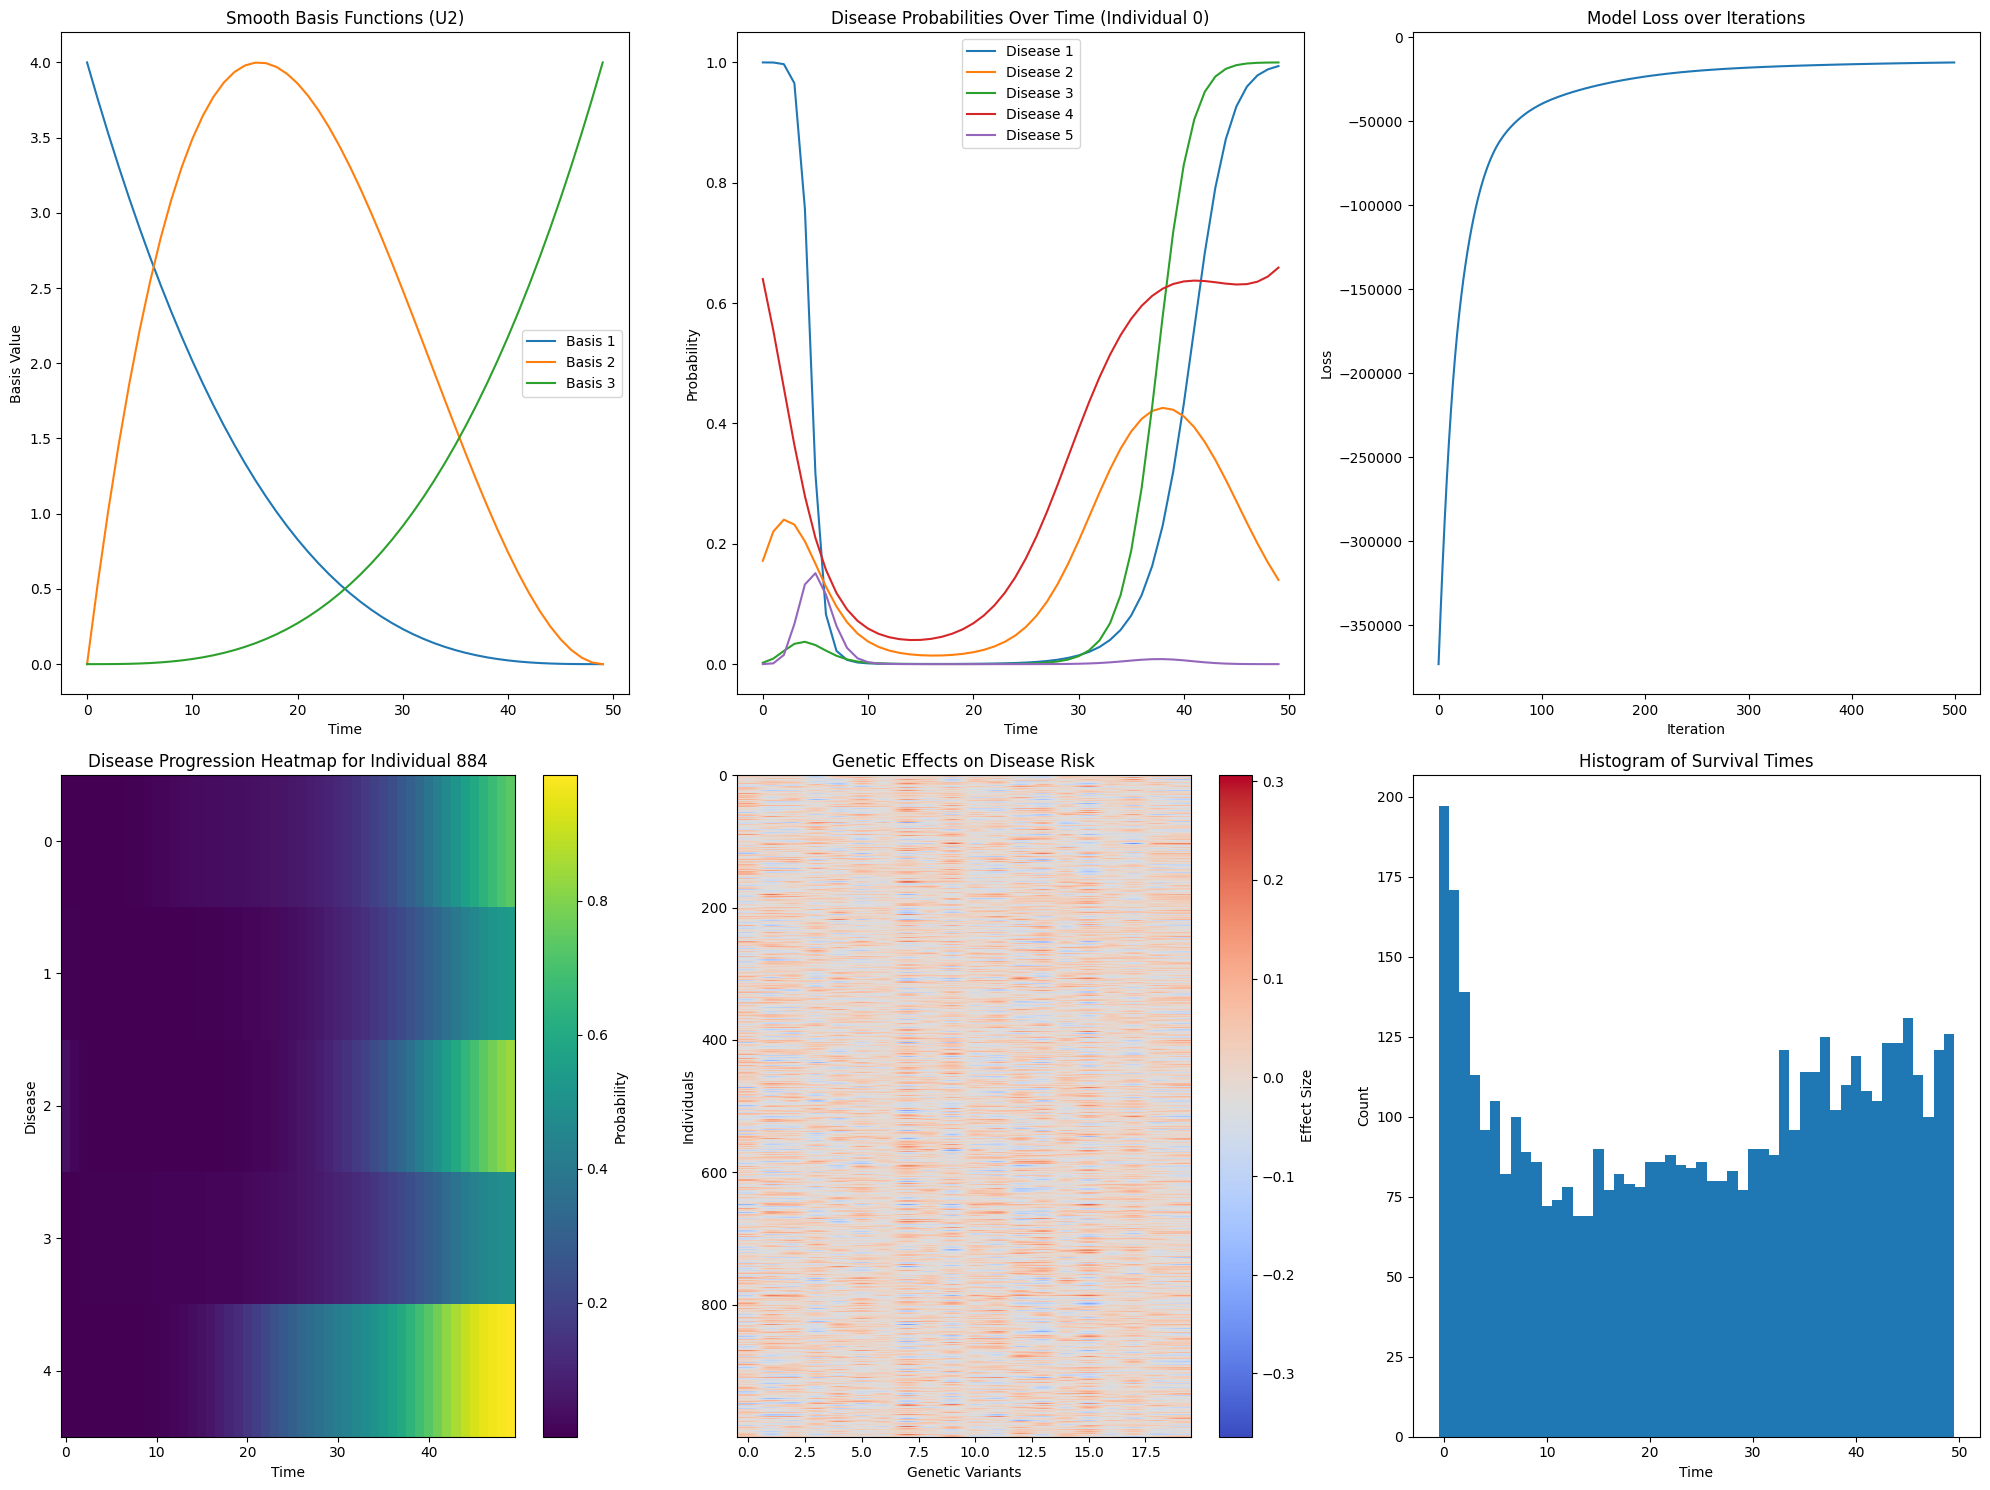

Mean survival time: 24.90
Median survival time: 26.00


In [30]:
# Plotting
plt.figure(figsize=(20, 15))

# Plot smooth basis functions
plt.subplot(2, 3, 1)
for r in range(R1):
    plt.plot(true_model.U2[:, r], label=f'Basis {r+1}')
plt.title('Smooth Basis Functions (U2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Basis Value')

# Plot disease probabilities over time
plt.subplot(2, 3, 2)
pi_fitted = expit(model_fit.compute_theta())
for d in range(D):
    plt.plot(pi_fitted[0, d, :], label=f'Disease {d+1}')
plt.title('Disease Probabilities Over Time (Individual 0)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()

# Plot loss curve
plt.subplot(2, 3, 3)
plt.plot(losses)
plt.title('Model Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Plot individual heatmap
plt.subplot(2, 3, 4)
sample_individual = np.random.randint(N)
plt.imshow(pi_fitted[sample_individual], aspect='auto', cmap='viridis')
plt.title(f'Disease Progression Heatmap for Individual {sample_individual}')
plt.xlabel('Time')
plt.ylabel('Disease')
plt.colorbar(label='Probability')

# Plot genetic effects
plt.subplot(2, 3, 5)
genetic_effect = np.einsum('pkr,nkr->np', true_model.B, true_model.U1)
plt.imshow(genetic_effect, aspect='auto', cmap='coolwarm')
plt.title('Genetic Effects on Disease Risk')
plt.xlabel('Genetic Variants')
plt.ylabel('Individuals')
plt.colorbar(label='Effect Size')

# Plot survival times histogram
plt.subplot(2, 3, 6)
plt.hist(S.flatten(), bins=T, range=(0, T), align='left')
plt.title('Histogram of Survival Times')
plt.xlabel('Time')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print some statistics about the survival times
print(f"Mean survival time: {np.mean(S):.2f}")
print(f"Median survival time: {np.median(S):.2f}")

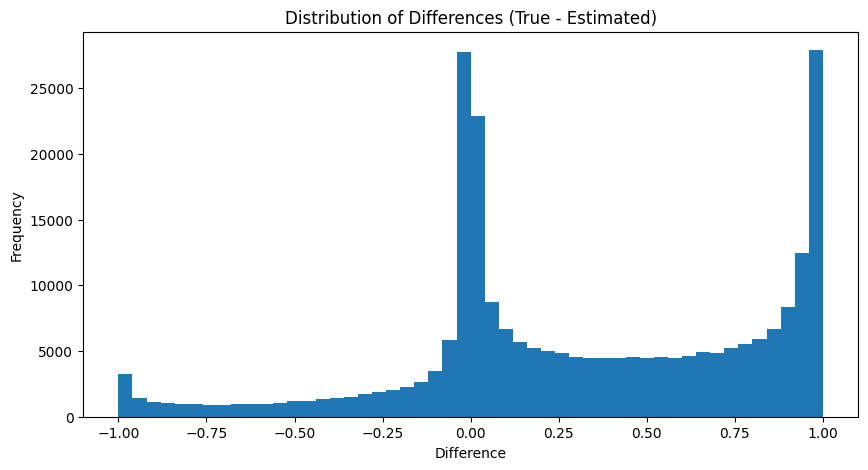

In [31]:
differences = pi_true - pi_fit
plt.figure(figsize=(10, 5))
plt.hist(differences.flatten(), bins=50)
plt.title('Distribution of Differences (True - Estimated)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

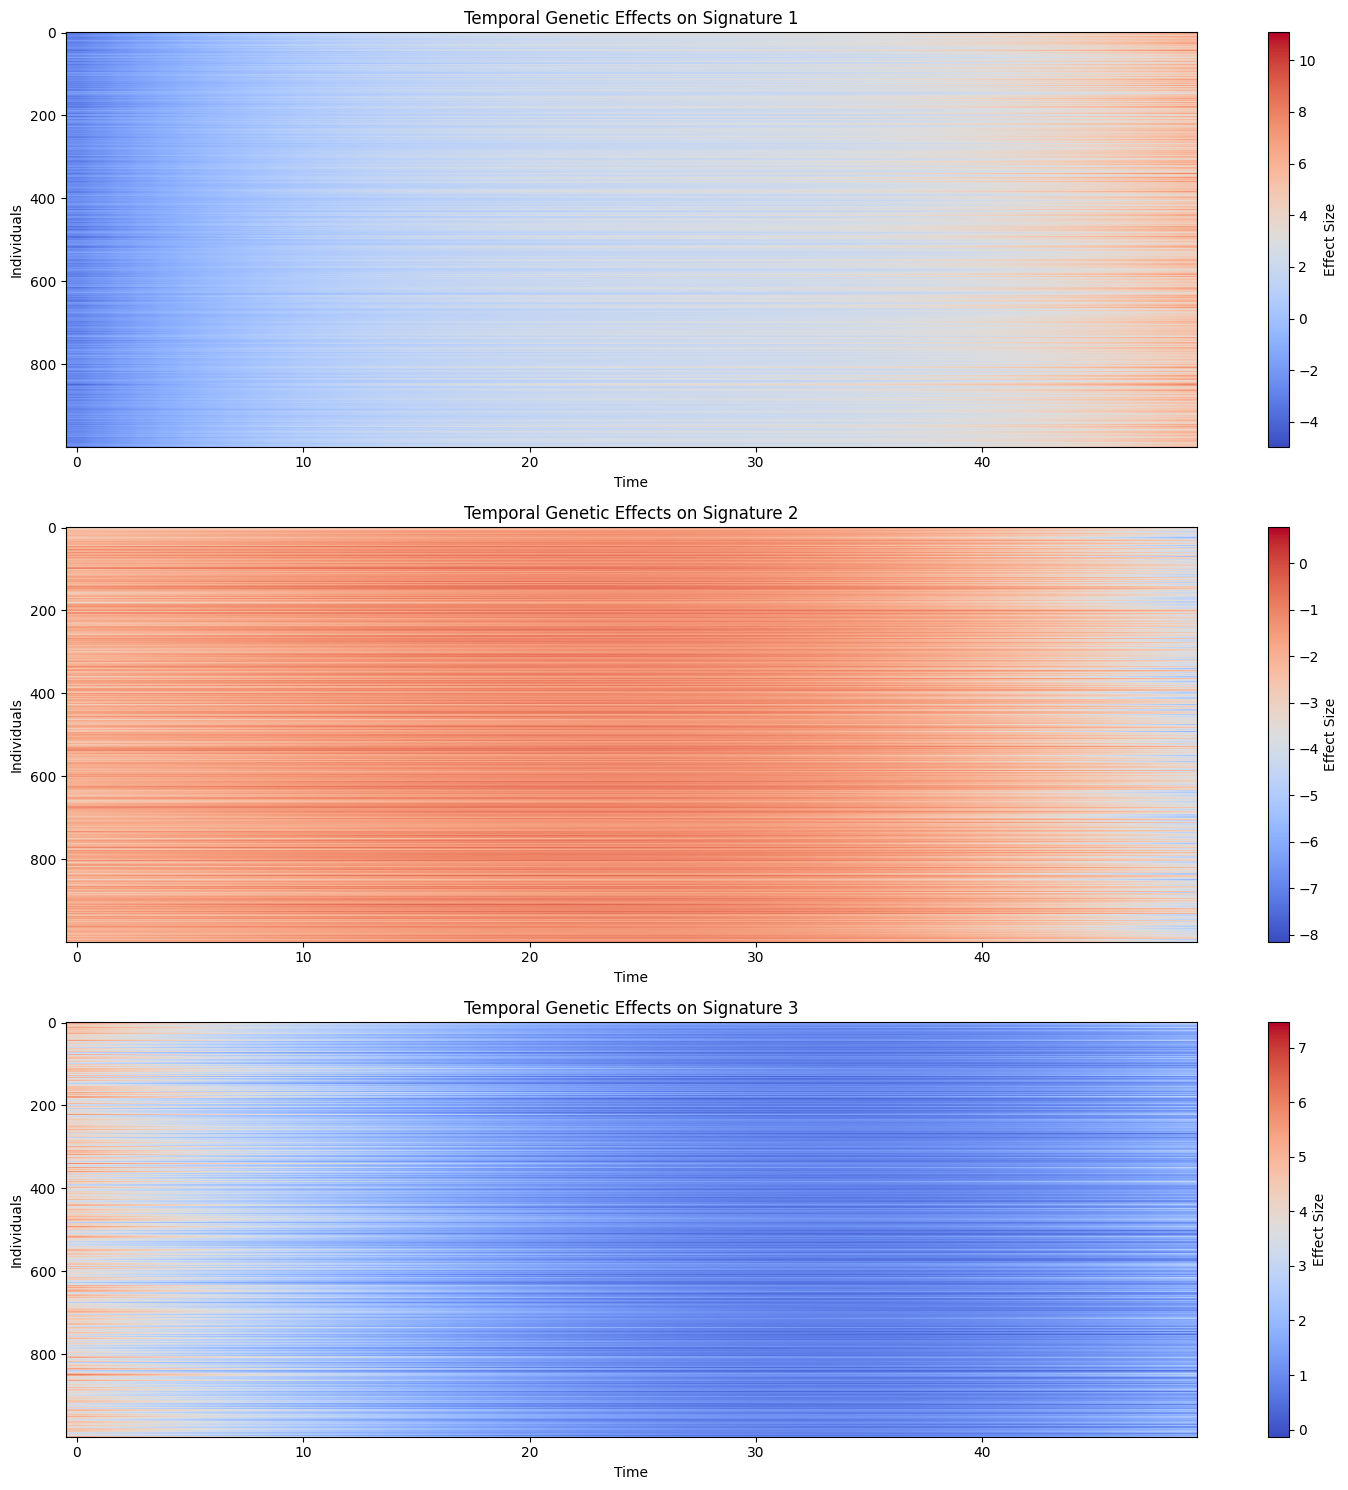

In [32]:
# Compute genetic effects on signatures
genetic_effect = np.einsum('np,pkr->nkr', model_fit.G, model_fit.B)
genetic_effect.shape
temporal_genetic_effect = np.einsum('nkr,tr->nkt', genetic_effect, model_fit.U2)

plt.figure(figsize=(15, 5 * model_fit.K))
for k in range(model_fit.K):
    plt.subplot(model_fit.K, 1, k+1)
    plt.imshow(temporal_genetic_effect[:, k, :], aspect='auto', cmap='coolwarm')
    plt.title(f'Temporal Genetic Effects on Signature {k+1}')
    plt.xlabel('Time')
    plt.ylabel('Individuals')
    plt.colorbar(label='Effect Size')

plt.tight_layout()
plt.show()

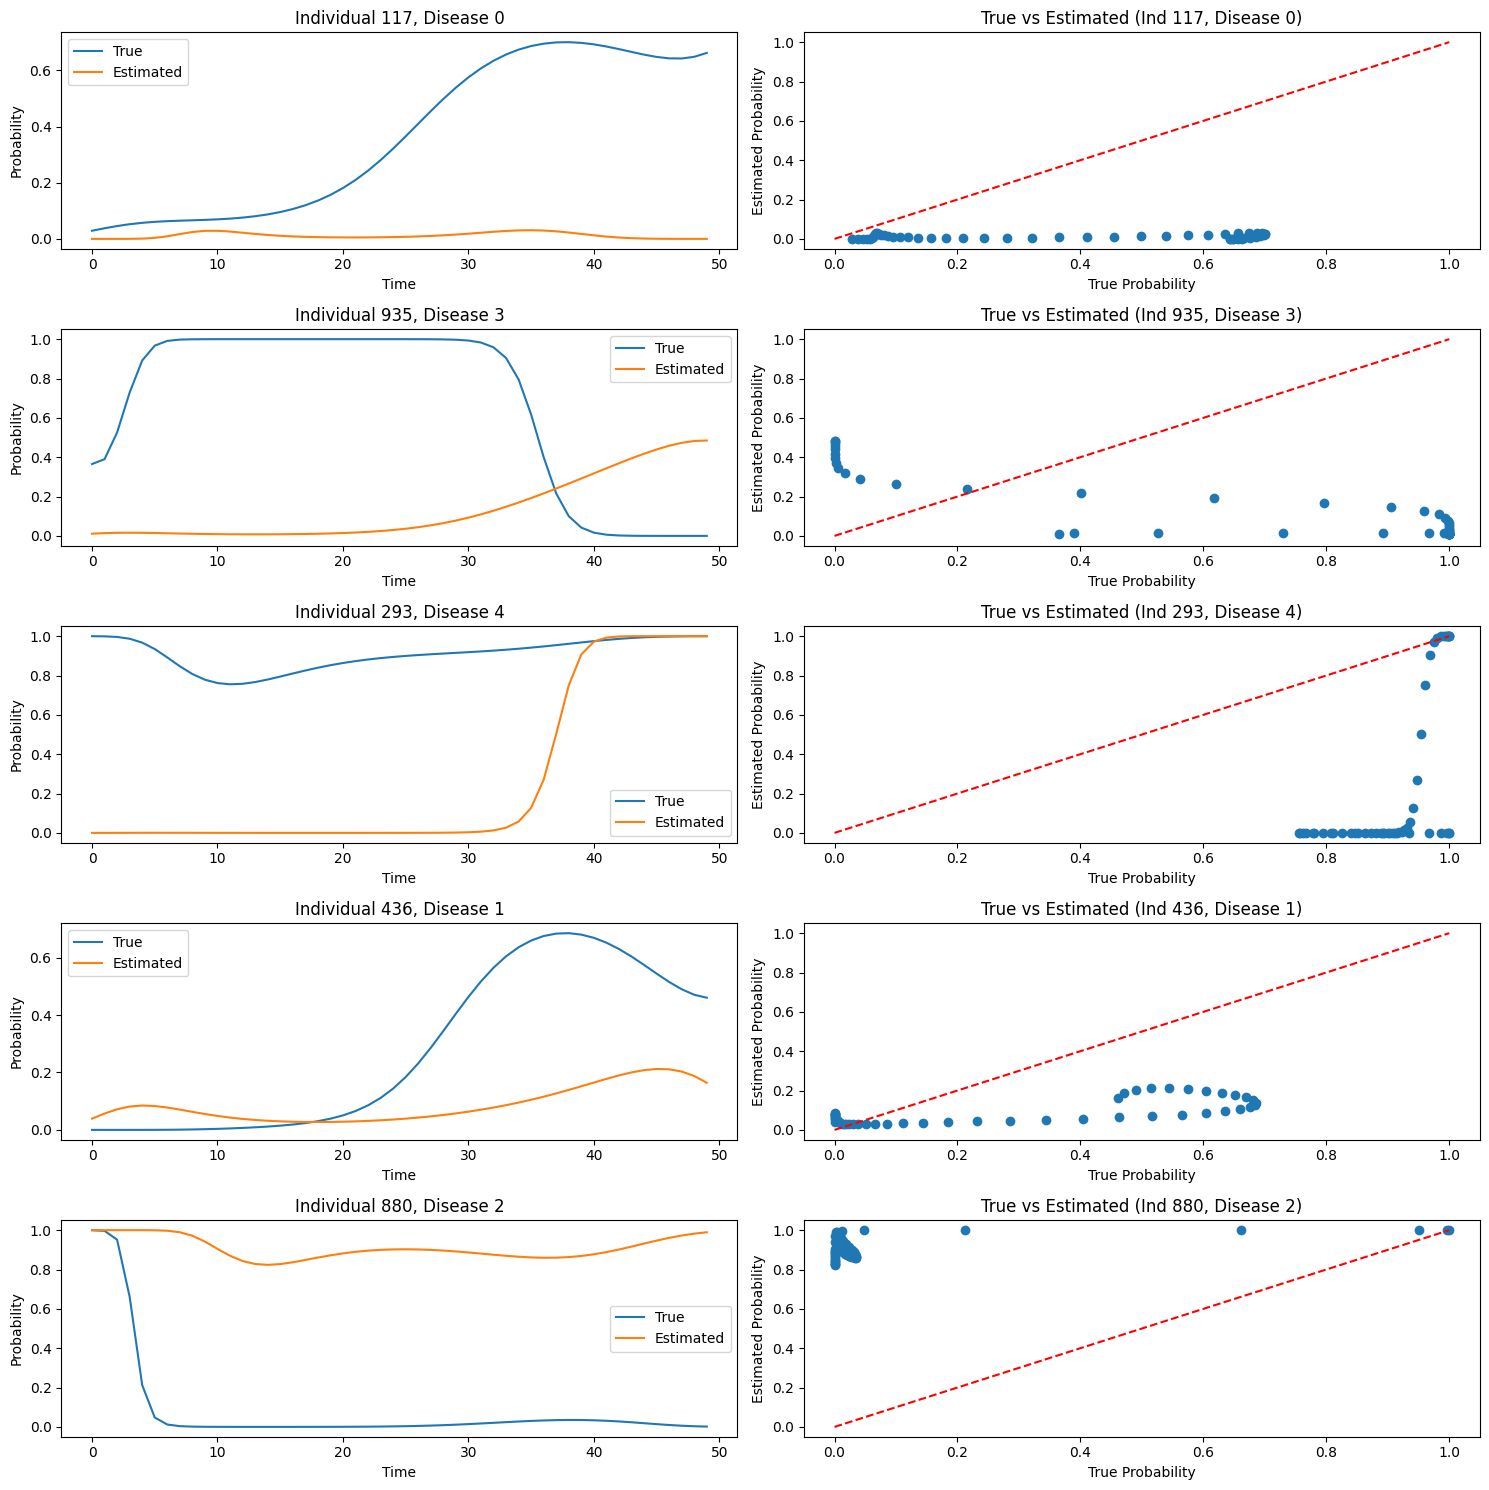

Overall correlation between true and estimated probabilities: 0.0429


In [33]:

# Plot true vs estimated pi for a few randomly selected individuals and diseases
num_samples = 5
sample_individuals = np.random.choice(N, num_samples, replace=False)
sample_diseases = np.random.choice(D, num_samples, replace=False)

plt.figure(figsize=(15, 15))
for i, (n, d) in enumerate(zip(sample_individuals, sample_diseases)):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(pi_true[n, d, :], label='True')
    plt.plot(pi_fit[n, d, :], label='Estimated')
    plt.title(f'Individual {n}, Disease {d}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.scatter(pi_true[n, d, :], pi_fit[n, d, :])
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.xlabel('True Probability')
    plt.ylabel('Estimated Probability')
    plt.title(f'True vs Estimated (Ind {n}, Disease {d})')

plt.tight_layout()
plt.show()

# Compute overall correlation
true_flat = pi_true.flatten()
estimated_flat = pi_fit.flatten()
correlation = np.corrcoef(true_flat, estimated_flat)[0, 1]
print(f"Overall correlation between true and estimated probabilities: {correlation:.4f}")